# Transfer learning with Tensor FLow Part 3 : Scalling Up

Scalling up to 101000 images base line to beat 51% accuracy

In [1]:
# Check to see if we're using a gpu
!nvidia-smi

Tue Jan 10 01:14:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous note books we have created a series of helper funtions so lets download it

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-10 01:14:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-10 01:14:21 (73.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions to use in ouer notebook
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,compare_historys,walk_through_dir

## 101 Food Classes: working with less data

our goal is to beat orignal paper with ten ppercent of data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-01-10 01:14:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   124MB/s    in 13s     

2023-01-10 01:14:38 (117 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# how many imaegs classes are there 
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in 

In [6]:
# setup data inputs

import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights=True,
                                                         monitor = "val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorperate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation= Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.)# rescale inputs of images to between 0 & 1,required when it isnt built in a model
],name = "data_augmentation" )


In [9]:
# Building a headless Functional EfficientNetB0 backboned model

# Creating input layer
Input = tf.keras.layers.Input(shape = (224,224,3))
x = data_augmentation(Input)
# Creating EfficientNet Backbone
backbone_model = tf.keras.applications.EfficientNetB0(include_top=False)
backbone_model.trainable=False
x= backbone_model(x,training=False)
# Creating a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Creating output layer
Output = tf.keras.layers.Dense(101,activation="softmax")(x)

# Building model
model_1 = tf.keras.models.Model(Input,Output)

# Compiling a model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
# Fiting the model
history_all_classes_10_percent =model_1.fit(train_data,
            epochs=5,
            validation_data=test_data,
            validation_steps =int(0.25*len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="food_101_mode_1")]
    )

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/food_101_mode_1/20230110-011458
Epoch 1/5
237/237 [==============================] - 98s 358ms/step - loss: 3.3826 - accuracy: 0.2697 - val_loss: 2.5142 - val_accuracy: 0.4259
Epoch 2/5
237/237 [==============================] - 78s 327ms/step - loss: 2.2080 - accuracy: 0.4949 - val_loss: 2.0191 - val_accuracy: 0.5097
Epoch 3/5
237/237 [==============================] - 71s 298ms/step - loss: 1.8261 - accuracy: 0.5670 - val_loss: 1.8923 - val_accuracy: 0.5217
Epoch 4/5
237/237 [==============================] - 70s 292ms/step - loss: 1.6115 - accuracy: 0.6121 - val_loss: 1.7864 - val_accuracy: 0.5362
Epoch 5/5
237/237 [==============================] - 68s 285ms/step - loss: 1.4648 - accuracy: 0.6440 - val_loss: 1.7461 - val_accuracy: 0.5424


In [ ]:
# Evaluate on full test data
feature_extraction_results = model_1.evaluate(test_data)
feature_extracton_results

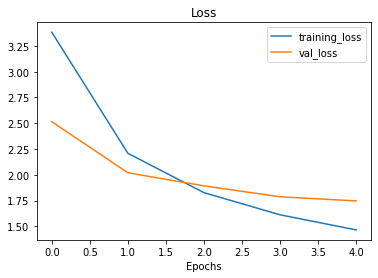

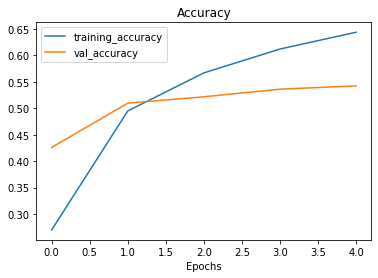

In [11]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

In [12]:
# Unfreeze all of the layers in base model
backbone_model.trainable = True

# Refreeze every layer except the last 5
for layer in backbone_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile the model as we have made changes to it
model_1.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr=0.0001),
              metrics =["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# What layers in the model are trainable
for layer in model_1.layers:
  print(layer.name,layer.trainable)

input_1 True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
dense True


In [19]:
# What layers are trainable in the back bone model
for layer in model_1.layers[-3].layers:
  print(layer.name,layer.trainable)

input_2 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [21]:
fine_tune_epochs = 10
initial_epoch = 5
# Fine tune the model_1
history_all_classes_10_percent_fine_tune =model_1.fit(train_data,
            epochs=fine_tune_epochs,
            initial_epoch=history_all_classes_10_percent.epoch[-1],
            validation_data=test_data,
            validation_steps =int(0.15*len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="food_101_mode_1_fine_tunning")]
    )

Saving TensorBoard log files to: transfer_learning/food_101_mode_1_fine_tunning/20230110-014327
Epoch 5/10
237/237 [==============================] - 59s 217ms/step - loss: 1.2075 - accuracy: 0.6816 - val_loss: 1.6742 - val_accuracy: 0.5546
Epoch 6/10
237/237 [==============================] - 50s 209ms/step - loss: 1.0936 - accuracy: 0.7064 - val_loss: 1.6465 - val_accuracy: 0.5633
Epoch 7/10
237/237 [==============================] - 50s 208ms/step - loss: 1.0106 - accuracy: 0.7290 - val_loss: 1.6203 - val_accuracy: 0.5646
Epoch 8/10
237/237 [==============================] - 50s 211ms/step - loss: 0.9437 - accuracy: 0.7481 - val_loss: 1.6071 - val_accuracy: 0.5736
Epoch 9/10
237/237 [==============================] - 46s 191ms/step - loss: 0.8868 - accuracy: 0.7640 - val_loss: 1.6511 - val_accuracy: 0.5630
Epoch 10/10
237/237 [==============================] - 45s 190ms/step - loss: 0.8297 - accuracy: 0.7747 - val_loss: 1.6370 - val_accuracy: 0.5670


In [24]:
# Evaluate on the whole dataset
all_classes_10_percent_fine_tune_results = model_1.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 64s 80ms/step - loss: 1.4823 - accuracy: 0.6062


[1.4822607040405273, 0.6062178015708923]

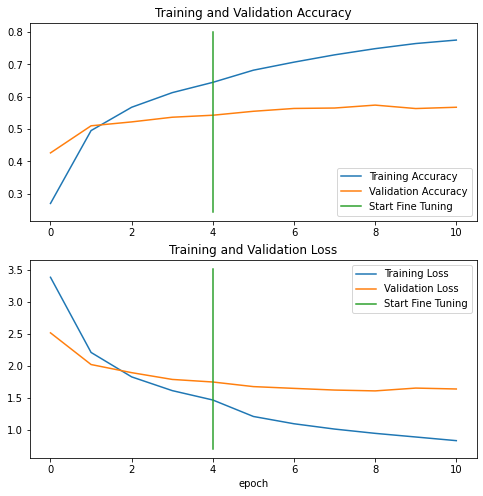

In [27]:
# Compare the history of both models
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Save and loading our model

In [28]:
# Save our fine tuned model
model_1.save("drive/MyDrive/101_food_classes_10_percent_saved")

In [30]:
# load and avaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved")

In [31]:
# Evaluate loaded model and compare results to model_1
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 63s 78ms/step - loss: 1.4823 - accuracy: 0.6062


In [32]:
loaded_model_results
all_classes_10_percent_fine_tune_results

[1.4822607040405273, 0.6062178015708923]

## Evaluatin performace of the big dog model across all the different classes

In [34]:
import tensorflow as tf
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)


--2023-01-10 02:06:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   121MB/s    in 0.4s    

2023-01-10 02:06:30 (121 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [35]:
# loading the downlaoded model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) 

In [36]:
# Evalaute the loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 61s 76ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [37]:
## Making predictions with our trained model
pred_porbs = model.predict(test_data,verbose=1)

790/790 [==============================] - 64s 79ms/step


In [40]:
# How many predictions are there 
len(pred_porbs)

25250

In [41]:
# What are the shape of predictions
pred_porbs.shape 

(25250, 101)

In [42]:
# Lets see what the first 10 predictions look like
pred_porbs[:10]

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [4.7313261e-01, 1.2931234e-07, 1.4805571e-03, ..., 5.9750129e-04,
        6.6969093e-05, 2.3469318e-05],
       [4.4571854e-02, 4.7265522e-07, 1.2258522e-01, ..., 6.3498674e-06,
        7.5318649e-06, 3.6778811e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2310996e-05, ..., 1.2291390e-03,
        1.5792685e-09, 9.6395743e-05]], dtype=float32)

In [44]:
# what does the first look like
pred_porbs[0],len(pred_porbs[0]),sum(pred_porbs[0])

(array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
        8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
        1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
        2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
        6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
        1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
        8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
        2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
        1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
        1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
        8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
        2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
        3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
        8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
        3.5306264e-05, 3.2489010e-05, 6.7314875e

In [48]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_porbs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_porbs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0 : {pred_porbs[0].argmax()}" )

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542041e-02 3.5742053e-06 4.1376803e-02 1.0660536e-09 8.1613978e-09
 8.6639664e-09 8.0927055e-07 8.5652584e-07 1.9859037e-05 8.0977844e-07
 3.1727685e-09 9.8673934e-07 2.8532150e-04 7.8048906e-10 7.4230199e-04
 3.8916383e-05 6.4740493e-06 2.4977257e-06 3.7891168e-05 2.0678289e-07
 1.5538468e-05 8.1507341e-07 2.6230621e-06 2.0010727e-07 8.3827535e-07
 5.4215934e-06 3.7391037e-06 1.3150533e-08 2.7761499e-03 2.8051867e-05
 6.8562162e-10 2.5574906e-05 1.6688929e-04 7.6407003e-10 4.0452901e-04
 1.3150634e-08 1.7957395e-06 1.4448203e-06 2.3062935e-02 8.2466863e-07
 8.5365861e-07 1.7138630e-06 7.0525307e-06 1.8402273e-08 2.8553430e-07
 7.9483771e-06 2.0681496e-06 1.8525223e-07 3.3619774e-08 3.1522568e-04
 1.0410943e-05 8.5448448e-07 8.4741873e-01 1.0555466e-05 4.4094878e-07
 3.7404185e-05 3.5306264e-05 3.2489010e-05 6.7314875e-05 1.2852592e-08
 2.6219760e-10 1.0318110e-05 8.5744046e-05 1.

In [49]:
test_data.class_names[52]

'gyoza'

In [53]:
# Get the pred classes of each label
pred_classes = pred_porbs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [55]:
# How many pred classes do we have
len(pred_classes)

25250

In [57]:
# To get our test labels we need to unreval our data set
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [58]:
len(y_labels)

25250

## Evaluate our models predictions 

In [59]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [61]:
# Lets try scikit-learn accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [64]:
# Does this metric come close to our model's evaluate results
import numpy as np 
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Making a confussion metrics 

In [65]:
from helper_functions import make_confusion_matrix

In [66]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [70]:
# We need to make changes to make confusion metrix function
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix
     

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

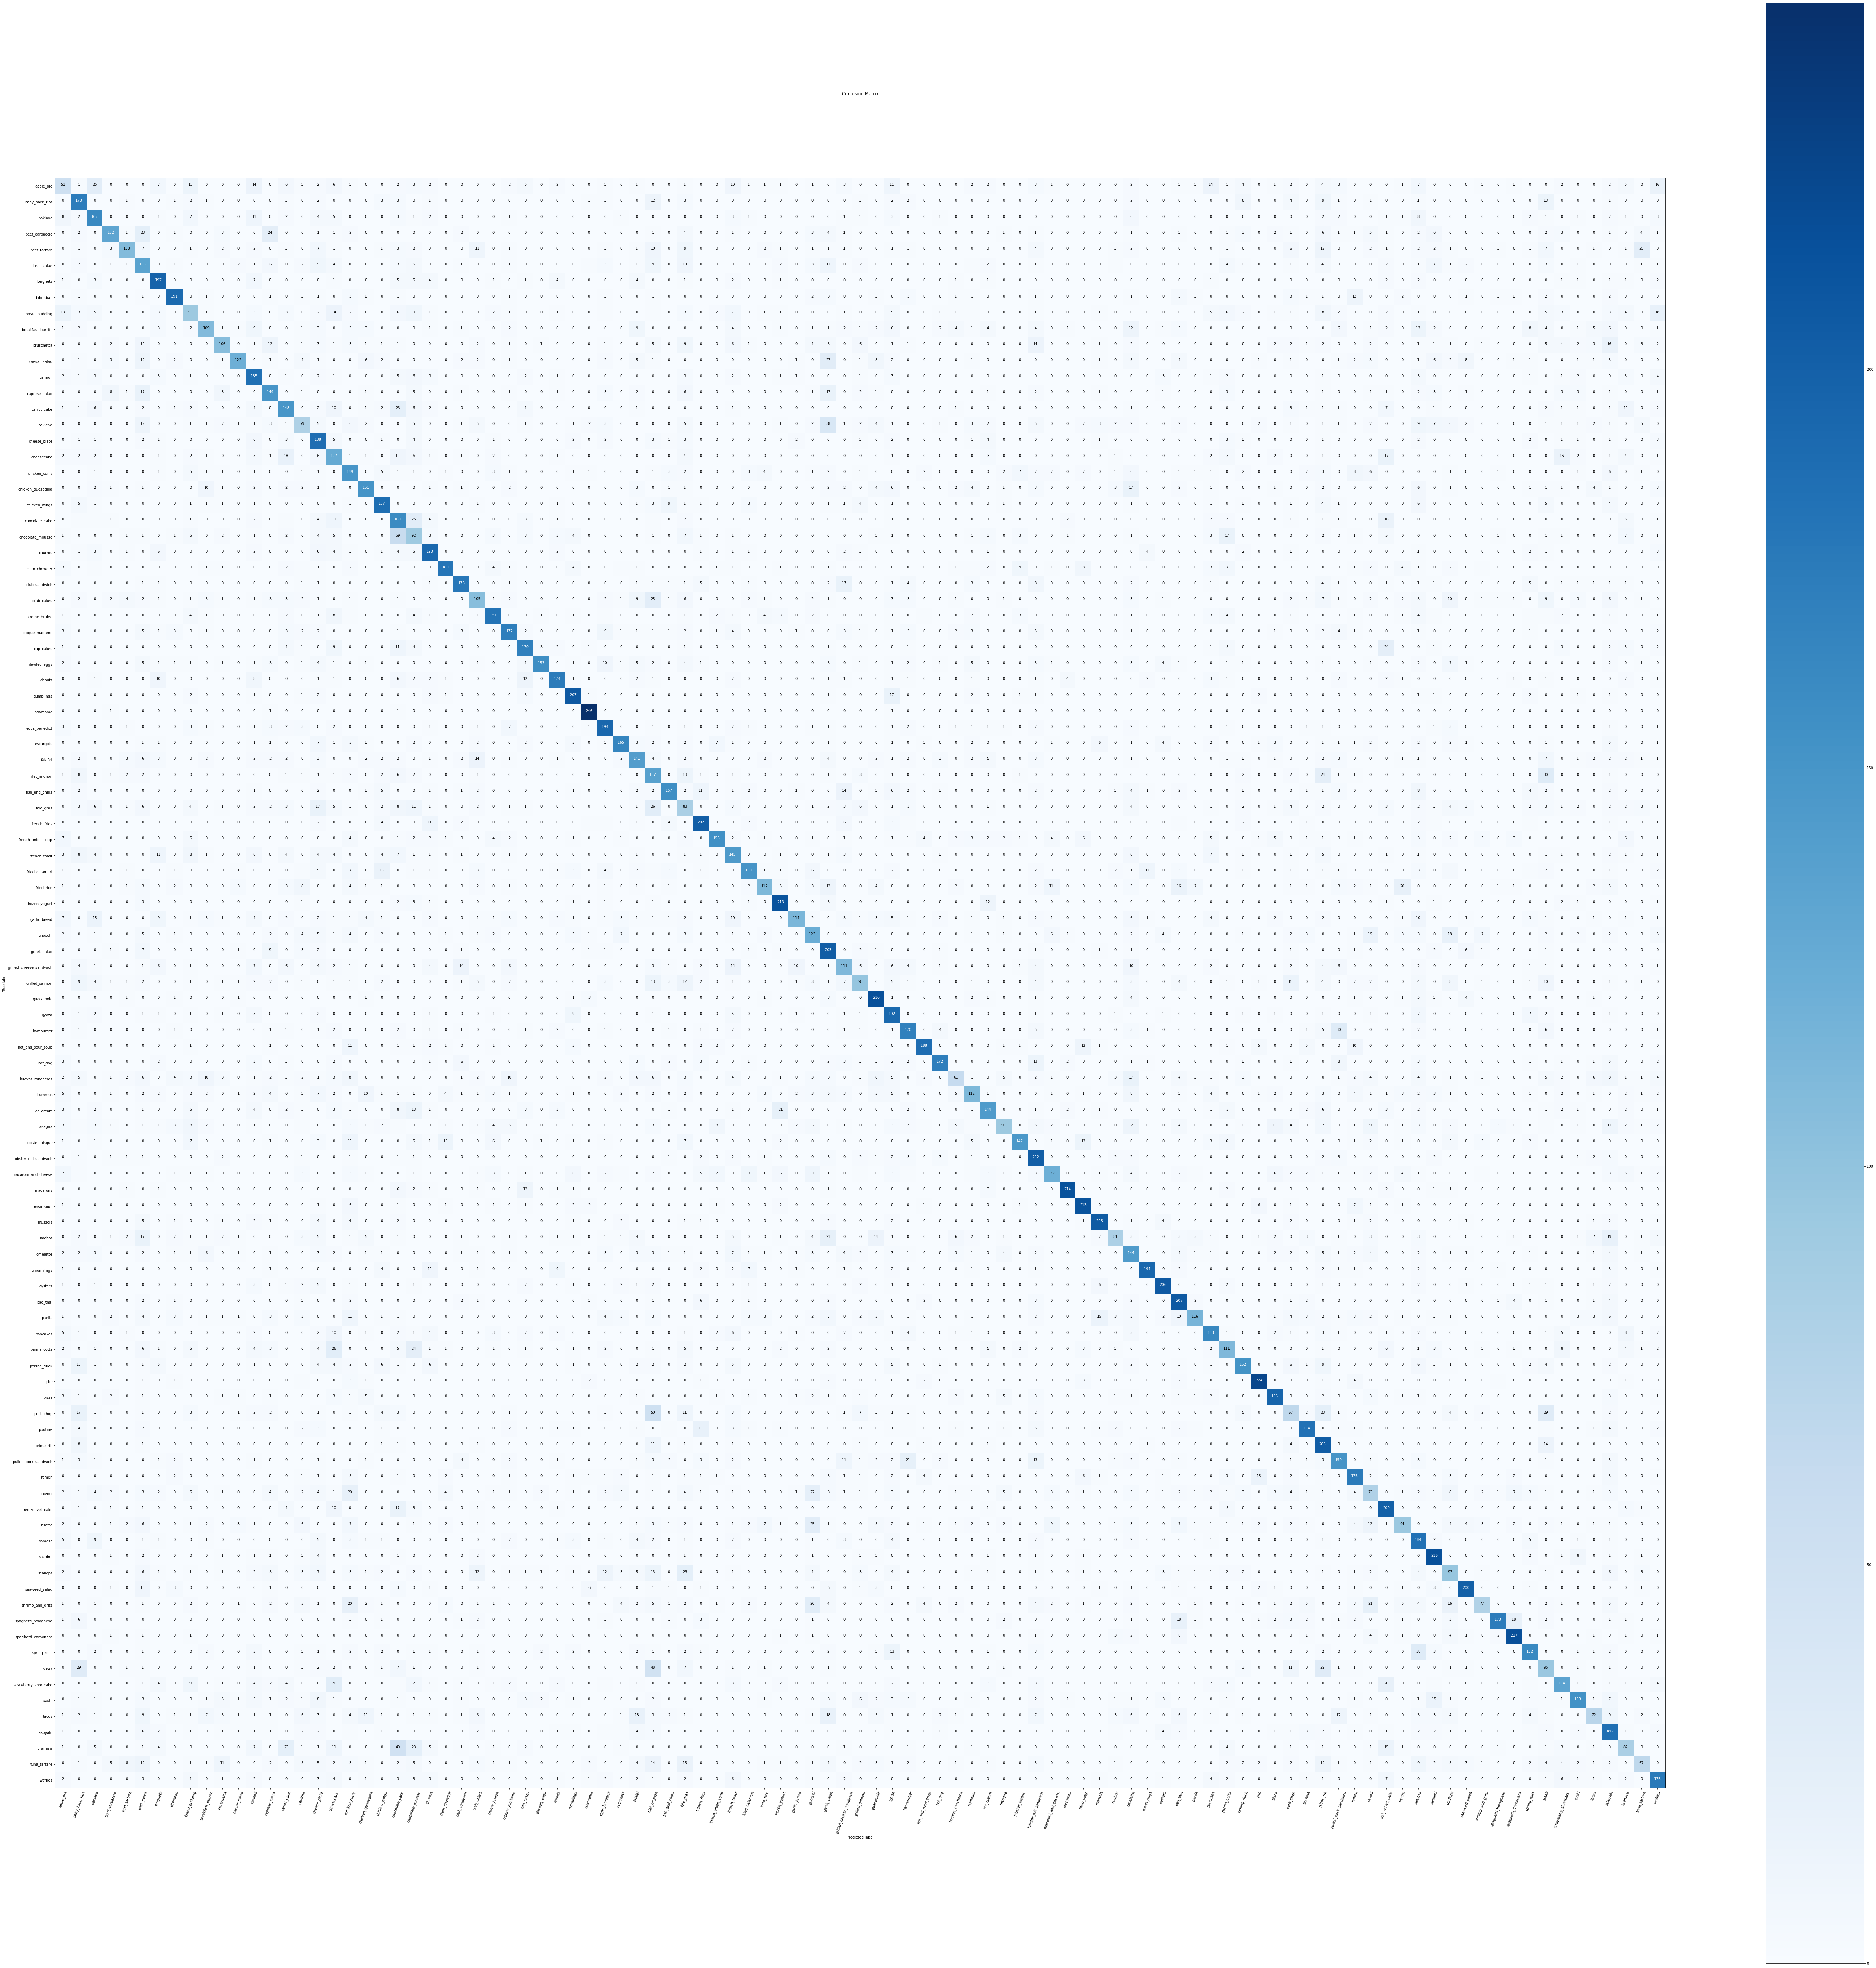

In [72]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 10,
                      savefig=True)

In [ ]:
## Lets keep the evaluation train going time for a classification report